# `WARNING`
### DO NOT RERUN this notebook. It will cause an error since the input data is not available in the repository due to confidentiality reason.

In [1]:
in_path = "../data/interim/"
out_path = "../data/processed/data_master.pkl"

In [2]:
from os.path import dirname
import os, sys, inspect

currentdir = os.getcwd()
parentdir = dirname(currentdir)

sys.path.insert(0,parentdir)

# Libs
All libraries needed are imported here.

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

from src.utils import dump_to_pickle, change_major_detector
from src.visualize import plot_compare_dist, plot_compare_categorical

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load Data
Each cleansed data from previous notebooks are loaded here.

In [4]:
OPCS_master = pd.read_pickle(in_path+'OPCS_master.pkl')
OA_master = pd.read_pickle(in_path+'OA_master.pkl')
HS_master = pd.read_pickle(in_path+'HS_master.pkl')

Columns from OPCS data are reselected here. Only `Last_CGPA` is used among all other GPA columns, because we only interested in the performance of each student at the end of the year / the end of their semester.

In [5]:
OPCS_used = OPCS_master[['NIM', 'form_number', 'major_code_opcs', 'major_name_opcs', 'Last_CGPA']]

### Merge OA - OPCS - HS
All 3 cleansed data will be merged with inner join method.

In [6]:
data = pd.merge(OPCS_used, HS_master, on='NIM', how='inner')
data = data.merge(OA_master, on='form_number', how='inner')

Here curriculum filter is performed again to ensure the data no longer contains international curriculum.

In [7]:
curr_filtered = ['Social', 'Science']
data = data.loc[data.curriculum_name.isin(curr_filtered)]

In [8]:
data.shape

(2101, 22)

In [9]:
data.head()

,NIM,form_number,major_code_opcs,major_name_opcs,Last_CGPA,ENG,MATH,BIO,CHEM,PHY,ECON,GEO,SOC,FINAL,major_code_oa,major_name_oa,gender,school_prop,school_name,school_state,school_geo_unit,curriculum_name
0,01011180001,1831100382,01011,Manajemen,3.25,73.25,70.75,NaN,NaN,NaN,86.50,73.75,79.25,30.80,01011,Manajemen,Female,SMA,SMAN 1 SIDIKALANG,SUMUT,SUM,Social
1,01011180002,1811100709,01011,Manajemen,1.06,77.75,64.75,NaN,NaN,NaN,79.25,80.00,76.25,25.95,01011,Manajemen,Male,SMA,SMA Islam Al-Azhar 8 Bekasi,JABAR,JAV,Social
2,01011180003,1811100388,01011,Manajemen,2.07,70.25,66.75,NaN,NaN,NaN,79.50,77.50,82.25,27.40,01011,Manajemen,Male,SMA,SMA Katolik St. Peter,NTT,SUN,Social
3,01011180004,1831100016,01011,Manajemen,2.91,82.25,85.00,NaN,NaN,NaN,71.75,77.75,72.75,28.40,01011,Manajemen,Male,SMA,SMA El Shadai Magelang,JATENG,JAV,Social
4,01011180005,1811100684,01011,Manajemen,3.28,85.25,78.00,80.25,75.5,78.5,NaN,NaN,NaN,33.90,01011,Manajemen,Male,SMK,SMK Eran Batu 2,SULSEL,SUL,Science


# Handling Missing Values

In [10]:
data.isnull().sum()

NIM                   0
form_number           0
major_code_opcs       0
major_name_opcs       0
Last_CGPA             0
ENG                   4
MATH                  4
BIO                1011
CHEM               1011
PHY                1011
ECON               1093
GEO                1093
SOC                1093
FINAL                 0
major_code_oa         0
major_name_oa         0
gender                0
school_prop          99
school_name          99
school_state         99
school_geo_unit      99
curriculum_name       0
dtype: int64

### Impute Missing Subjects Features
Science students won't have Social courses grades, hence they will `NULL` values and vice versa. Therefore, imputation needed to fill Social courses grades for Science students and to fill Science courses grades for Social students.

In [11]:
#impute subject score with 0
subj_cols = [
    'BIO', 'CHEM', 'ECON', 'ENG',
    'GEO', 'MATH', 'PHY', 'SOC'
]

Here we replace the `NULL` with 0.

In [12]:
for col in subj_cols:
    data[col] = data[col].fillna(0)

### Impute Missing School Features
School features like `school_prop` and `school_state` also have missing values. 

In [13]:
#impute prop and state with mode
school_cols = ['school_prop', 'school_state']

We replace the missing values with the column's mode.

In [14]:
for col in school_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

Since we can derive `school_geo_unit` from `school_state`, then we impute the missing `school_geo_unit` using `school_state` information below.

In [15]:
#impute geo_unit based on state

dict_reg = {
    'JAV': ['DIY', 'DKIJKT', 'BANTEN', 'JATENG',  'JABAR', 'JATIM'],
    'SUM': ['SUMUT', 'SUMBAR', 'ACEH', 'LAMPUN', 'SUMSEL', 'RIAU', 'BENGKU', 'JAMBI', 'BANGKA', 'PEKANB'],
    'KAL': ['KALBAR', 'KALTGH', 'KALSEL', 'KALUT', 'KALTIM'],
    'SUL': ['SULSEL', 'SULBAR', 'SULUT', 'SULTGH', 'SULTGR', 'GORONT'],
    'SUN': ['NTT', 'NTB', 'BALI'],
    'MAL': ['MALUKU', 'MALUTA'],
    'PAP': ['PAPBRT', 'PAPUA'],
    'LN': ['LN']
}

In [16]:
for geo_unit, state in dict_reg.items():
    data.loc[data.school_state.isin(state), 'school_geo_unit'] = geo_unit

In [17]:
data.isnull().sum()

NIM                 0
form_number         0
major_code_opcs     0
major_name_opcs     0
Last_CGPA           0
ENG                 0
MATH                0
BIO                 0
CHEM                0
PHY                 0
ECON                0
GEO                 0
SOC                 0
FINAL               0
major_code_oa       0
major_name_oa       0
gender              0
school_prop         0
school_name        99
school_state        0
school_geo_unit     0
curriculum_name     0
dtype: int64

# Label Definition
`Last_CGPA` is the target variable. From the target variable we define which student is failed and which isn't. For every student who has `Last_CGPA` below 2.00 will be flagged `1` (fail), otherwise will be flagged as `0` (success). 

2.00 is chosen as threshold due to the fact that UPH has a regulation that states every student needs to have minimum CGPA of 2.00 at the end of semester 4 in order to proceed to next semester.

In [18]:
data['fail'] = data['Last_CGPA'].apply(lambda x: 1 if x<2 else 0)

# EDA + Feature Extraction

### Class Size
Here we can see that we have imbalanced class size. This will affect the performance of classifier built later. The classifier model will most likely to predict the given data as `0` since it is the majority class.

Text(0.5, 1.0, 'Class Size')

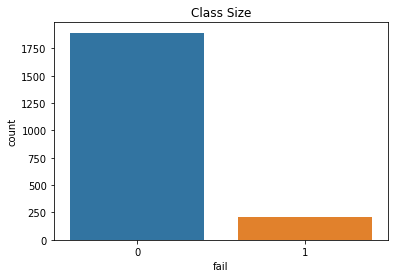

In [39]:
sns.countplot(data.fail)
plt.title('Class Size')

In [20]:
data.fail.value_counts()

0    1893
1     208
Name: fail, dtype: int64

### Last_CGPA Distribution
The target variable distribution is left-skewed. The data is centered around 3.00 value. If we chose 2.00 as class threshold, the distribution explains why we have a very imbalanced class size. As we can see from this distribution, there are more students who have CGPA greater than 2.00 than students who have CGPA less than 2.00. 

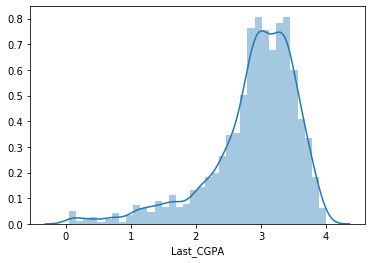

In [21]:
sns.distplot(data['Last_CGPA'])

### HS Scores Distribution
The distributions of high school courses scores are also left-skewed. The data are centered around 80 for each course and around 30 for Final score. It seems that the data does not have any outliers.

In [22]:
hs_scores_feat = data.select_dtypes(include='float64').drop('Last_CGPA', axis=1).columns.values

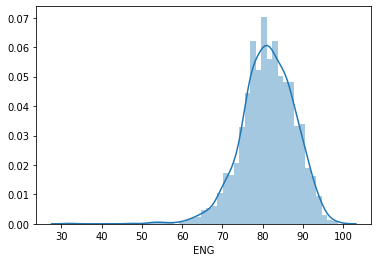

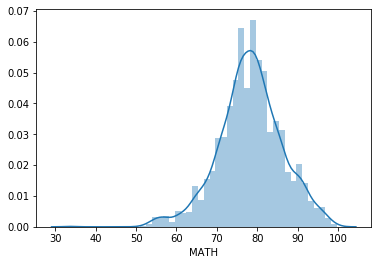

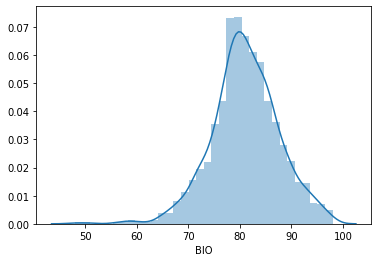

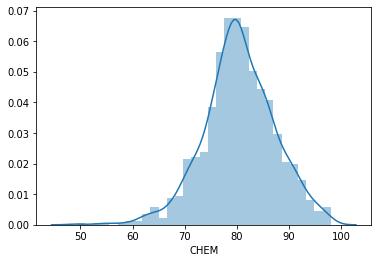

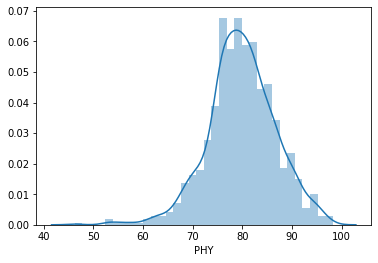

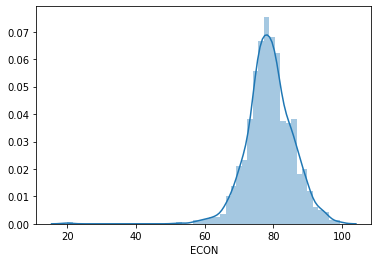

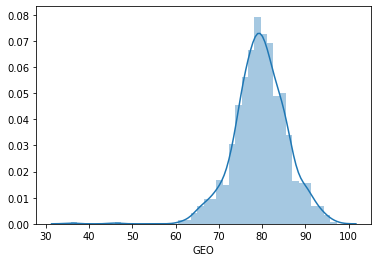

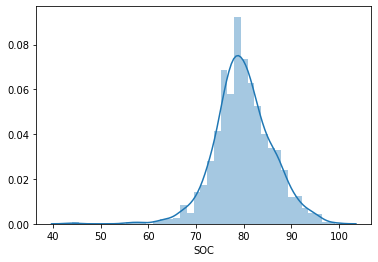

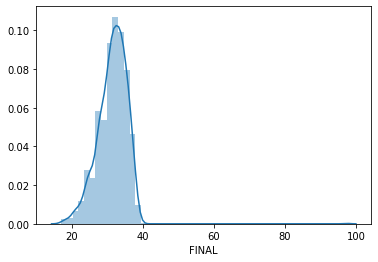

In [23]:
for col in hs_scores_feat:
    sns.distplot(data[data[col]!=0][col])
    plt.show()

### Flag Changed Major
By comparing the major in the admission form and the major registered in the UPH system (OPCS), we can flag if the students change major during the first year period. If the major code is not the same in both data, we assume that they have changed major.

`change_major_detector` function is created for this purpose. You can check the raw code [here](../src/utils.py)

In [24]:
data['has_changed_major'] = \
data.apply(lambda row: change_major_detector(row['major_code_oa'], row['major_code_opcs']),
          axis=1)

By plotting the `countplot` we can see that the number of students who has changed major during the first year period is much smaller than students who stay.

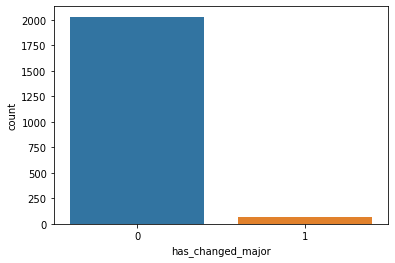

In [25]:
sns.countplot(data.has_changed_major)

In [26]:
data['has_changed_major'].value_counts()

0    2029
1      72
Name: has_changed_major, dtype: int64

We try to plot two `Last_CGPA` distributions, blue distribution refers to the students who stay (not changed major) and orange distribution refer to the students who has changed their major. Seems like the distributions is quite similar, there is no obvious different characteristic between students who has changed major and students who stay.

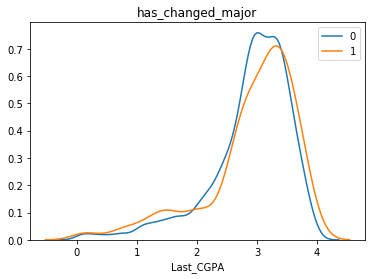

In [27]:
disc_feat = 'has_changed_major'
cont_feat = 'Last_CGPA'

plot_compare_dist(data, disc_feat, cont_feat)

Below plot shows the percentage of fail students within the category of `has_changed_major`. It shows that students who changed major have slightly higher percentage (14%) of failing compared to the students who stay (10%). 

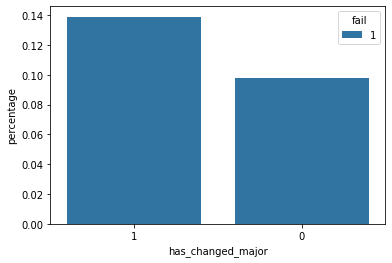

In [28]:
feature = "has_changed_major"
target = "fail"

plot_compare_categorical(data, feature, target)

### Major

In [29]:
major_cnt = data.major_name_opcs.value_counts()

The plot below shows the population of students inside each major at UPH. Top 3 majors are `Manajemen`, `Pengelolaan Perhotelan` and `Hukum`. While `PJJ Ilmu Komunikasi` is the major with least number of students.

Text(0.5, 1.0, 'Major Count')

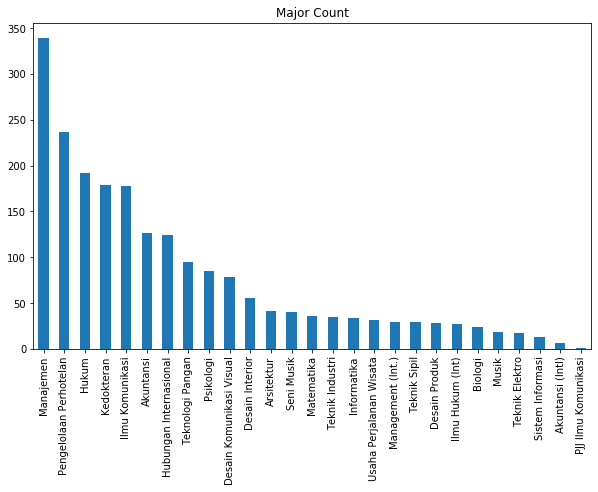

In [30]:
plt.figure(figsize=(10,6))
major_cnt.plot.bar()
plt.title('Major Count')

Below plot shows top 10 majors with the highest percentage of failing. We can see that `Teknik Industri` has the highest percentage (38%) of students who fail, followed by `Teknik Sipil` (34%).

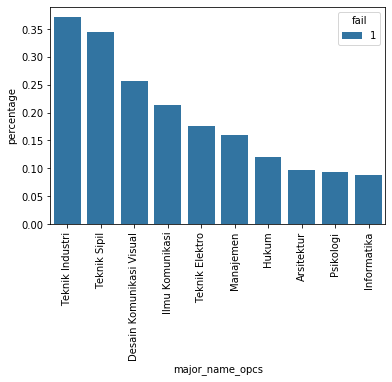

In [31]:
feature = "major_name_opcs"
target = "fail"

plot_compare_categorical(data, feature, target, top_n=10, rotation=90)

### Grouping Major to Faculty
Here the available majors are grouped to larger category: faculty.

In [32]:
dict_faculty = {
    'BS' : ['Manajemen', 'Akuntansi', 'Management (Int.)', 'Akuntansi (Intl)'],
    
    'SOD' : ['Arsitektur', 'Desain Komunikasi Visual', 'Desain Interior', 'Desain Produk'],
    
    'FaST' : ['Teknik Sipil', 'Teknik Elektro', 'Teknik Industri', 
                   'Teknologi Pangan', 'Matematika', 'Biologi'],
    
    'FISIP' : ['Ilmu Komunikasi', 'Hubungan Internasional', 'PJJ Ilmu Komunikasi'],
    
    'Law' : ['Hukum', 'Ilmu Hukum (Int)'],
    
    'CoM' : ['Seni Musik', 'Musik'],
    
    'Medicine' : ['Kedokteran'],
    
    'FIK' : ['Sistem Informasi', 'Informatika'],
    
    'Psy' : ['Psikologi'],
    
    'STPPH' : ['Pengelolaan Perhotelan', 'Usaha Perjalanan Wisata']
}

In [33]:
data['faculty'] = None
for faculty, major in dict_faculty.items():
    data.loc[data.major_name_opcs.isin(major), 'faculty'] = faculty

Faculty that has the biggest population is `Business School` while `Fakultas Ilmu Komputer` has the least population among all.

Text(0.5, 1.0, 'Faculty Count')

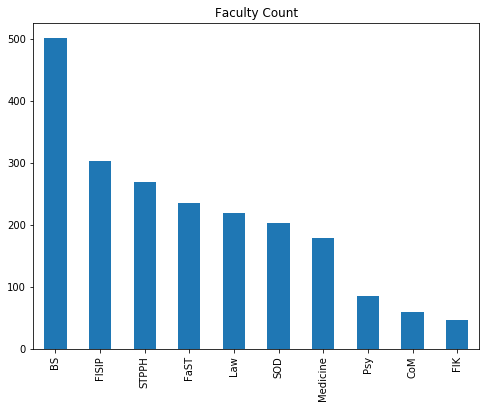

In [34]:
fac_cnt = data.faculty.value_counts()

plt.figure(figsize=(8,6))
fac_cnt.plot.bar()
plt.title('Faculty Count')

Below plot shows the percentage of failing within the `faculty` categories. `Faculty of Science and Technology` is the faculty with highest percentage (14%) of students who fail, while `Conservatory of Music` has the lowest percentage (2%).

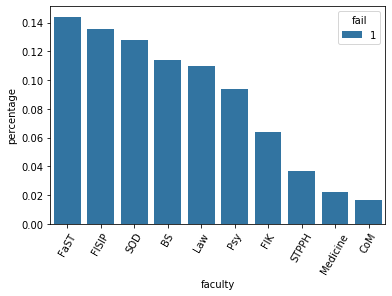

In [35]:
feature = "faculty"
target = "fail"

plot_compare_categorical(data, feature, target, top_n=10, rotation=60)

### Curriculum

There are more students who took `Science` track in their high school compared to students who took `Social` track.

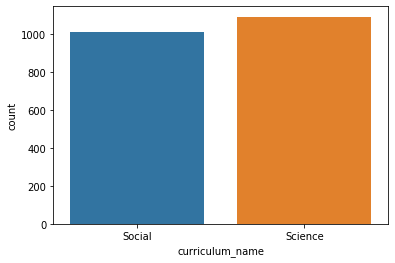

In [36]:
sns.countplot(data.curriculum_name)

Even though there are more students in `Science` track, the plot below shows that students who took `Social` track has slightly higher percentage (11%) of failing compared to students who took `Science` track (8%).

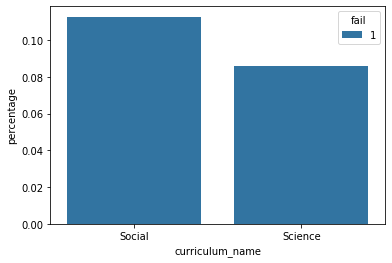

In [37]:
feature = "curriculum_name"
target = "fail"

plot_compare_categorical(data, feature, target)

# Dump to Pickle

In [38]:
dump_to_pickle(data, out_path)